For this assignment, we followed the following tutorial: https://keras.io/examples/vision/nl_image_search/

In [18]:
# importing libraries
import os
import collections
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

First, we downloaded and extracted the dataset, placing it into our working directory. There is a folder titled images containing JPEGs of all the image training data. Additionally, there is a captions.txt that contains comma-separated values on each line, the first being the image name and the second being a caption for that image.

In [19]:
# maps image path to list of all its captions
image_path_to_caption = collections.defaultdict(list)
# populates this dictionary by iterating through captions.txt
inFile = open("captions.txt")
count = 0
for line in inFile:
    count += 1
    if count == 1: continue
    fields = line.split(",")
    fileName = fields[0]
    caption = ",".join(fields[1:])
    image_path_to_caption["Images/" + fileName].append(caption)
print("There are " + str(count - 1) + " captions.") # excludes headers
inFile.close()

There are 40455 captions.


In [20]:
# gets list of all image paths
image_paths = list(image_path_to_caption.keys())
print("There are " + str(len(image_paths)) + " images.")

There are 8091 images.


In [21]:
# image count used for training and how many captions used per image
train_size = int(len(image_paths) * 0.08)
captions_per_image = 2
# image count for testing
valid_size = int(len(image_paths) * 0.02)
# how many images stored in each tfrecords file
images_per_file = 2000

In [22]:
# slices image paths list to retrieve for training and testing
# calculates how many files are needed to store the images
# creates directories to hold training and testing data respectively
tfrecords_dir = "tfrecords"

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)

# creates Feature object that can be stored to tfrecord file
# from the byte string passed into function
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# creates Example object with features caption and raw_image
# the caption and raw image are converted to byte strings which are
# converted to Feature objects
def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# writes examples to tfrecords files
def write_tfrecords(file_name, image_paths):
    # stores captions and image paths
    caption_list = []
    image_path_list = []
    example_idx = 0
    # iterates through image paths, retrieving subset of
    # captions for each image and appending image path
    # and caption to their respective lists
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))
    # writes created examples to tfrecords file, returning
    # number of examples written
    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1

# writes examples to the appropriate number of tfrecords files
# returns number of examples written
def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

# writes training data to tf record files
train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

# writes testing data to td record files
valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


1294 training examples were written to tfrecord files.


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]

322 evaluation examples were written to tfrecord files.


In [23]:
# defines dictionary that describes expected features
# in Example objects read from tfrecord file
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}

# parses the features of a serialized tfrecord Example object
def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    # decodes image into image tensor
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features

#  returns TFRecordDataset object by converting serialized data
# to normal data for each file that matches a certain pattern
def get_dataset(file_pattern, batch_size):
    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(batch_size)
    )

In [24]:
# transforms image and text embeddings to same embedding space 
# with same dimensionality
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [25]:
# implementation for the image encoder
def create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
    # Loads pre-trained Xception model used as base encoder
    xception = keras.applications.Xception(include_top=False, weights="imagenet", pooling="avg")
    # Sets trainability of the base encoder
    for layer in xception.layers:
        layer.trainable = trainable
    # Takes images as inputs
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocesses input image
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate embeddings
    embeddings = xception(xception_input)
    # Projects embeddings produced by model
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    # Creates the image encoder model
    return keras.Model(inputs, outputs, name="vision_encoder")

In [26]:
# implementation for the caption encoder
def create_text_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
    # Loads BERT preprocessing module
    preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2", name="text_preprocessing")
    # Load pre-trained BERT model used as the base encoder
    bert = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=trainable)
    # Sets trainability of the base encoder.
    bert.trainable = trainable
    # Takes text as input
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess text
    bert_inputs = preprocess(inputs)
    # Generates embeddings
    embeddings = bert(bert_inputs)["pooled_output"]
    # Projects embeddings produced by model.
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    # Creates the caption encoder model
    return keras.Model(inputs, outputs, name="text_encoder")

In [27]:
# implementation of dual encoder
class DualEncoder(keras.Model):
    # 
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [28]:
num_epochs = 5  # In practice, train for at least 30 epochs
batch_size = 256

vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [29]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 0
Number of examples (caption-image pairs): 1294
Batch size: 256
Steps per epoch: 6
Epoch 1/5
6/6 [==============================] - 138s 22s/step - loss: 488.6470 - val_loss: 289.2113 - lr: 0.0010
Epoch 2/5
6/6 [==============================] - 131s 22s/step - loss: 275.0016 - val_loss: 186.6437 - lr: 0.0010
Epoch 3/5
6/6 [==============================] - 132s 22s/step - loss: 200.1839 - val_loss: 131.5740 - lr: 0.0010
Epoch 4/5
6/6 [==============================] - 133s 22s/step - loss: 158.3714 - val_loss: 90.3386 - lr: 0.0010
Epoch 5/5
6/6 [==============================] - 131s 22s/step - loss: 131.2440 - val_loss: 76.6353 - lr: 0.0010
Training completed. Saving vision and text encoders...


INFO:tensorflow:Assets written to: vision_encoder\assets


INFO:tensorflow:Assets written to: vision_encoder\assets


INFO:tensorflow:Assets written to: text_encoder\assets


INFO:tensorflow:Assets written to: text_encoder\assets


Models are saved.


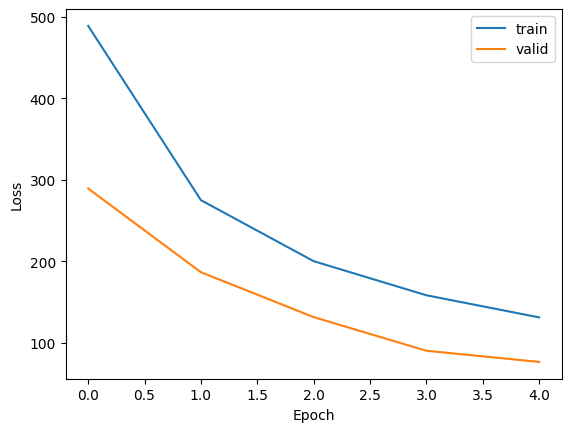

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()